# Improving Demand Forecasting
## Capstone Project 2: Modeling with ARIMA, SARIMA, and Prophet



In [41]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import itertools
import numpy as np
from random import random
from scipy import stats
from scipy.stats import normaltest
warnings.filterwarnings("ignore")
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import fbprophet
from fbprophet import Prophet

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess

PROJ_ROOT = os.pardir
%store -r ts
%store -r df

## ARIMA
ARIMA model includes the AR (Auto Regression) term, the I (Integrated) term, and the MA (Moving Average) term.

The I term is a full difference derived by subtracting one instant's value from another instant's value.

The AR term is a partial difference. The coefficient on the AR term explains the percent of a difference needed to be taken.

A MA term in a time series model is a past error (multiplied by a coefficient).

#### ACF and PACF
ACF and PACF plots help determine the important parameters in the ARIMA modeling function. The 3 terms (AR, I, and MA) of the ARIMA model correspond to 3 parameters (p, d, and q) in the modeling function. These parameters help model the major aspects of a times series: seasonality, trend, and noise.

Parameter p is associated with the AR aspect of the model, which incorporates past values i.e lags of dependent variable. If p is 5, the predictors for x(t) will be x(t-1)….x(t-5). Evaluating the PACF plot can help specify the value for p.

Parameter d is associated with the I term of the model, which affects the amount of differencing to apply to a time series. The transformation for trend stationarity that was done on this time series prior to modeling was a first order differencing, which means that in this case d is equal to 1.

Parameter q is the size of the MA window of the model. If q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average and actual value  at ith instant.

Consider a time series that was generated by an autoregression (AR) process with a lag of k. The ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

Consider a time series that was generated by a moving average (MA) process with a lag of k. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

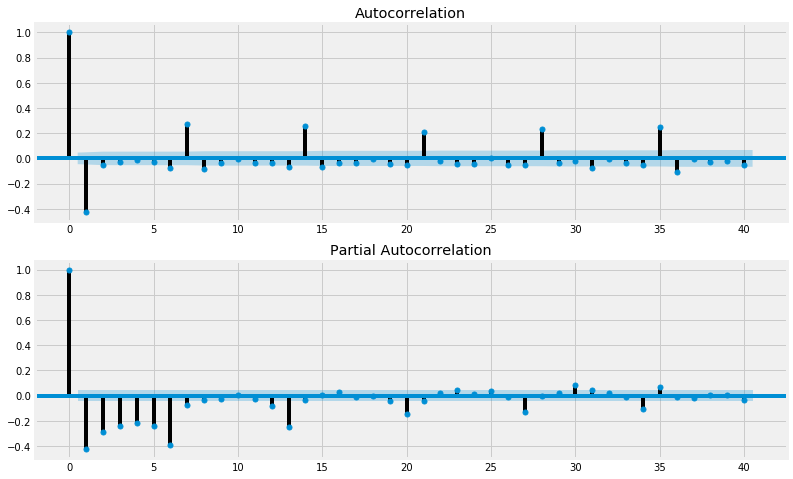

In [2]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts[0], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ts[0], lags=40, ax=ax2)
plt.show();

The ACF and PACF plots both show recurring patterns every 7 periods, which indicates a weekly pattern and significant seasonality. An S (Seasonal) term should be added and SARIMA used for modeling time series with seasonality.

The ACF tails out and the PACF cuts out at lag 6. Therefore, p equals 6.

The ACF cuts off at lag 1. Therefore, q equals 1.

In [47]:
# Get the fitted SARIMA models for each item in each store using p = 6, d = 1, and q = 0 
arima = SARIMAX(ts[0],trend='n',order=(6,1,1)).fit()

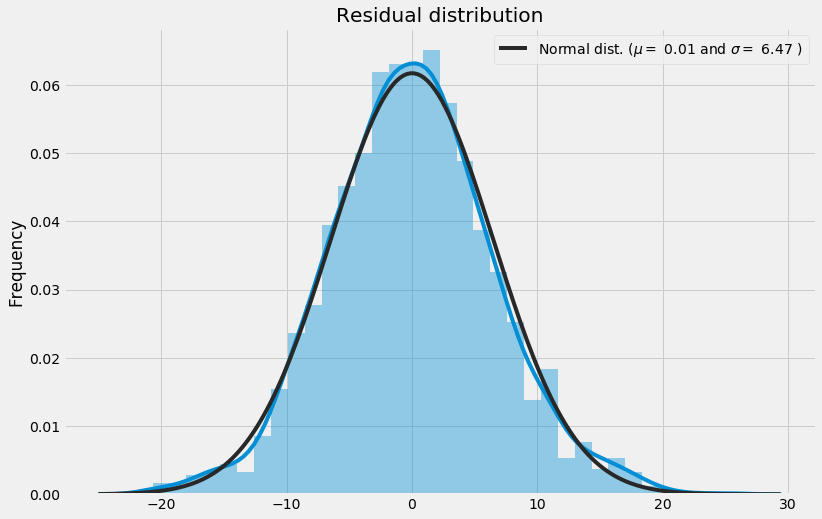

In [48]:
# Plot the residual distribution of the fitted model for item 1 at store 1
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)
sns.distplot(arima.resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(arima.resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.show();

The chi-squared statistics show a p-value of 0.004 being smaller than 0.05 for the fitted model of the series for item 1 at store 1. Therefore, the residual is not of normal distribution despite appearances. 

In [49]:
# Check the statistics of the fitted model for item 1 at store 1
print(normaltest(arima.resid))

NormaltestResult(statistic=10.834346953095384, pvalue=0.004439677783089412)


In [51]:
# Get the order value combinations to try during tuning of parameters p, d, and q
q = range(0, 7)
p = range(0, 7)
d = range(0, 1)
pdq = list(itertools.product(p, d, q))

In [52]:
# Fit models with different combinations of p, d, and q values
tune_arima = [SARIMAX(ts[0],trend='n',order=ao).fit(disp=False) for ao in pdq]

In [53]:
# Get the list index of the model with minimum AIC
aics = [x.aic for x in tune_arima]
min_aic_index = aics.index(min(aics))

# Summary of the model with minimum aic
tune_arima[min_aic_index].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1825
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -5487.503
Date:                Wed, 26 Feb 2020   AIC                          10997.007
Time:                        14:28:16   BIC                          11057.610
Sample:                             0   HQIC                         11019.362
                               - 1825                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7578      0.044     17.071      0.000       0.671       0.845
ar.L2         -1.3612      0.046    -29.593      0.000      -1.451      -1.271
ar.L3          0.6728      0.061     11.046      0.000       0.553       0.792
ar.L4         -0.9058      0.033    -27.294      0.000      -0.971      -0.841
ar.L5         -0.0505      0.031     -1.653      0.098      -0.110       0.009
ma.L1         -1.6822      0.040    -42.001      0.000      -1.761      -1.604
ma.L2          2.0443      0.078     26.100      0.000       1.891       2.198
ma.L3         -1.8592      0.095    -19.500      0.000      -2.046      -1.672
ma.L4          1.4763      0.073     20.164      0.000       1.333       1.620
ma.L5         -0.7721      0.034    -22.806      0.000      -0.838      -0.706
sigma2        25.1405      0.829     30.329      0.000      23.516      26.765
===================================================================================
Ljung-Box (Q):                      146.55   Jarque-Bera (JB):                19.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMA
There are four seasonal elements that are part of the SARIMA modeling function that can be configured:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. If m is 7 for daily data, then there is weekly seasonality.

Previously the ACF and PACF plots showed strong seasonality on a weekly cycle, so m equals 7 will be tried in the seasonal order of the SARIMA model below.

In [54]:
# Get seasonal order parameters value combinations
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [55]:
# Fit models with different combinations of p, d, q, P, D, Q and m values
tune_sarimax = [SARIMAX(ts[0],trend='n',order=ao,seasonal_order=so).fit(disp=False) for ao in pdq for so in seasonal_pdq]

MemoryError: Unable to allocate array with shape (61, 61, 1826) and data type float64

In [ ]:
# Get the list index of the model with minimum AIC
aics = [x.aic for x in tune_sarimax]
min_aic_index = aics.index(min(aics))

# Summary of the model with minimum aic
tune_sarimax[min_aic_index].summary()

In [3]:
# Create function to fit a SARIMA model for each item in each store
def sarima_seasonal(s,p,d,q,P,D,Q,m):
    mod = SARIMAX(s,trend='n',order=(p,d,q),seasonal_order=(P,D,Q,m)).fit(disp=False)
    return mod

In [10]:
# Get the first 100 fitted SARIMA models for each item in each store using p = 6, d = 1, q = 0, P = 1, D = 1, Q = 1, and m = 7
smods1 = [sarima_seasonal(x,6,1,0,1,1,1,7) for x in ts[:100]]

# Get the p-values of the first 100 fitted models residuals
pvals1 = [normaltest(x.resid)[1] for x in smods1]

Due to hardware constraints, 100 out of the 500 models were fitted and the p-values of the residuals retrieved. 37 out of the 100 fitted models have residuals with p-values less than 0.05, meaning that those residuals have non-normal distributions. This indicates that the seasonal order parameters still need to be tuned to achieve better fitting models.

In [27]:
# Check the number of p-values out of 100 that are smaller than 0.05
len([x for x in pvals1 if x < 0.05 ])

37

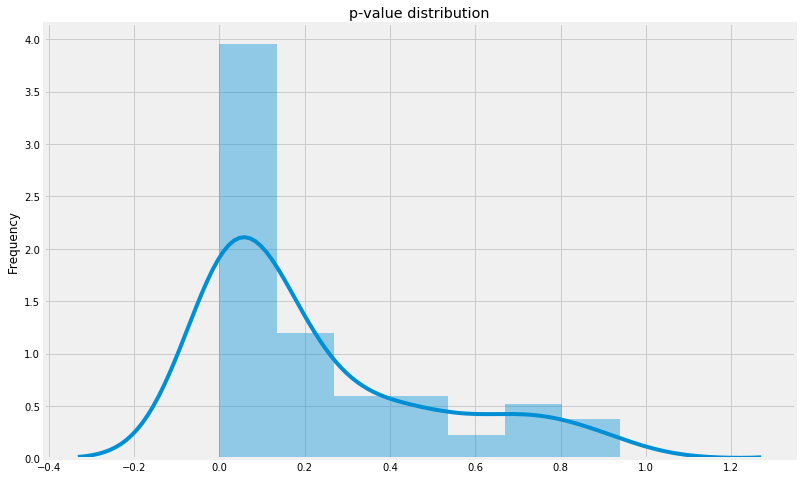

In [28]:
# Plot the distribution of the p-values to evaluate the first 100 fitted models
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.distplot(pvals1, ax = ax)
plt.ylabel('Frequency')
plt.title('p-value distribution')
plt.show();

## Tuning SARIMA Parameters
Before forecasting item sales with the models, the models can be further improved by tuning the hyperparameters of the function. Models are fitted using different combinations of the hyperparameters and the fitted model with the lowest AIC value has the optimal hyperparameters values.

In [21]:
# Get the order value combinations to try during tuning of parameters p and q
q = range(0, 7)
p = range(0, 7)
d = range(0, 1)
pdq = list(itertools.product(p, d, q))

In [22]:
# Fit models with different combinations of p, d, and q values
tune_q = [SARIMAX(ts[0],order=ao,enforce_stationarity=False,
             enforce_invertibility=False).fit(disp=False) for ao in pdq]

In [25]:
# Get the list index of the model with minimum AIC
tune_q_aic = [x.aic for x in tune_q]
min_aic_index = tune_q_aic.index(min(tune_q_aic))

The parameters p, d, and q that yielded the model with lowest AIC value have values of 4, 1, and 6. Due to hardware constraints, tuning was performed on just one time series (of one item at one store).

In [26]:
# Summary of the model with minimum aic
tune_q[min_aic_index].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1825
Model:               SARIMAX(4, 1, 6)   Log Likelihood               -5538.040
Date:                Wed, 08 Jan 2020   AIC                          11098.081
Time:                        16:34:48   BIC                          11158.635
Sample:                             0   HQIC                         11120.423
                               - 1825                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2496      0.097     -2.566      0.010      -0.440      -0.059
ar.L2         -0.0539      0.078     -0.693      0.489      -0.206       0.099
ar.L3         -0.3181      0.071     -4.467      0.000      -0.458      -0.179
ar.L4         -0.9201      0.088    -10.513      0.000      -1.092      -0.749
ma.L1         -1.7592      0.112    -15.747      0.000      -1.978      -1.540
ma.L2          0.5226      0.265      1.970      0.049       0.003       1.042
ma.L3          0.4215      0.295      1.430      0.153      -0.156       0.999
ma.L4          0.4054      0.262      1.545      0.122      -0.109       0.920
ma.L5         -1.4729      0.222     -6.633      0.000      -1.908      -1.038
ma.L6          0.8775      0.095      9.197      0.000       0.690       1.064
sigma2        23.7704      1.518     15.656      0.000      20.795      26.746
===================================================================================
Ljung-Box (Q):                      373.85   Jarque-Bera (JB):                13.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX models for the first 100 items are fitted using the tuned p, d, and q values. Even with tuned hyperparameters and taking into consideration weekly seasonality, SARIMAX still fails to predict much of the seasonality in the data. 

In [4]:
# Get the first 100 fitted SARIMA models for each item in each store using p = 6, d = 1, q = 6, P = 1, D = 1, Q = 1, and m = 7
smods2 = [sarima_seasonal(x,6,1,6,1,1,1,7) for x in ts[:100]]

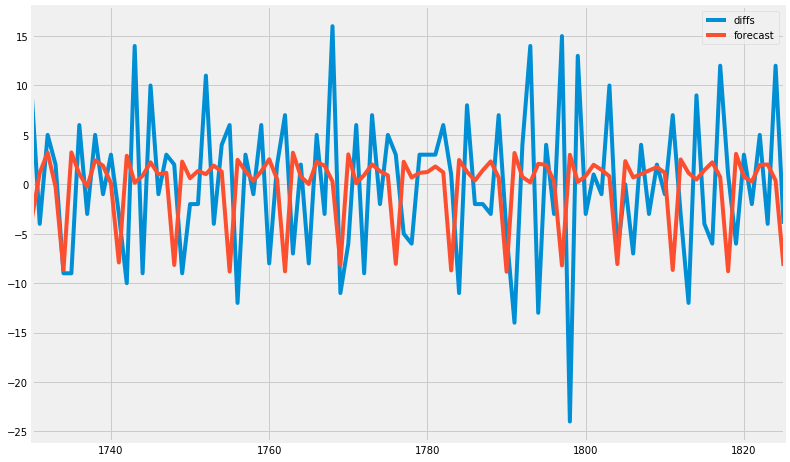

In [6]:
# Take last 3 months of item 1 at store 1 as validation data for prediction
start_index = 1730
end_index = 1826
df['diffs'] = df.sales - df.sales.shift(1)
df['forecast'] = smods2[0].predict(start = start_index, end= end_index, dynamic= True)  
df[start_index:end_index][['diffs', 'forecast']].plot(figsize=(12, 8))

## Prophet
Facebook's time series modeling package Prophet uses a trend-seasonality decomposition. It also provides more flexbility in that data with high seasonality need not be transformed prior to modeling.

In [12]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df,'date',False)
df.head()

,date,store,item,sales,month,forecast,diffs,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2013-01-01,1,1,13,2013-01,NaN,NaN,2013,1,1,1,1,1,1,False,True,False,True,False,True
1,2013-01-02,1,1,11,2013-01,NaN,-2.0,2013,1,1,2,2,2,1,False,False,False,False,False,False
2,2013-01-03,1,1,14,2013-01,NaN,3.0,2013,1,1,3,3,3,1,False,False,False,False,False,False
3,2013-01-04,1,1,13,2013-01,NaN,-1.0,2013,1,1,4,4,4,1,False,False,False,False,False,False
4,2013-01-05,1,1,10,2013-01,NaN,-3.0,2013,1,1,5,5,5,1,False,False,False,False,False,False


In [20]:
prophet_df = pd.DataFrame({'ds':df['date'],
                             'y':df['sales'],
                             'item':df['item'],
                             'store':df['store'],
                             'week':df['Week']})
prophet_df.head()

,ds,y,item,store,week
0,2013-01-01,13,1,1,1
1,2013-01-02,11,1,1,1
2,2013-01-03,14,1,1,1
3,2013-01-04,13,1,1,1
4,2013-01-05,10,1,1,1


In [21]:
prophet_df = prophet_df.query('item == 1 & store == 1')
prophet_df.groupby(['week','store','item'])['y'].mean().reset_index().head()

,week,store,item,y
0,1,1,1,13.970588
1,2,1,1,13.200000
2,3,1,1,14.114286
3,4,1,1,13.828571
4,5,1,1,14.342857


In [22]:
prediction_size = 31 
prophet_train = prophet_df[:-prediction_size]
prophet_train.tail(n=3)

,ds,y,item,store,week
1792,2017-11-28,14,1,1,48
1793,2017-11-29,28,1,1,48
1794,2017-11-30,15,1,1,48


In [23]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(prophet_train[['ds','y']])

In [24]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [25]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.483290,12.299101,24.037206,20.482472,20.483884,-2.054884,-2.054884,-2.054884,2.274361,2.274361,2.274361,1.120660,1.120660,1.120660,-5.449905,-5.449905,-5.449905,0.0,0.0,0.0,18.428406
1824,2017-12-30,20.485318,14.804014,25.901875,20.484365,20.486035,-0.106910,-0.106910,-0.106910,2.274361,2.274361,2.274361,2.993400,2.993400,2.993400,-5.374672,-5.374672,-5.374672,0.0,0.0,0.0,20.378408
1825,2017-12-31,20.487346,15.293060,27.085235,20.486308,20.488140,0.739436,0.739436,0.739436,2.274361,2.274361,2.274361,3.780462,3.780462,3.780462,-5.315387,-5.315387,-5.315387,0.0,0.0,0.0,21.226782


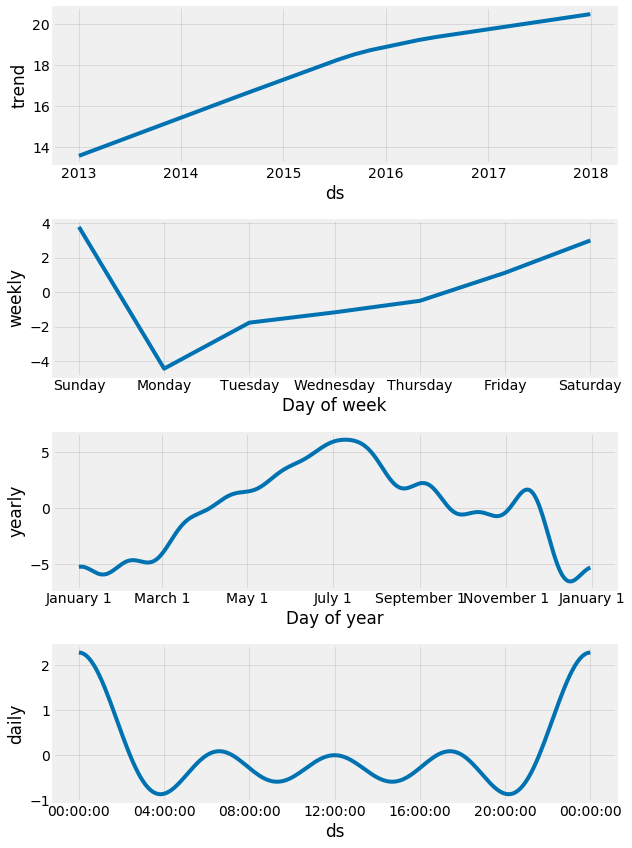

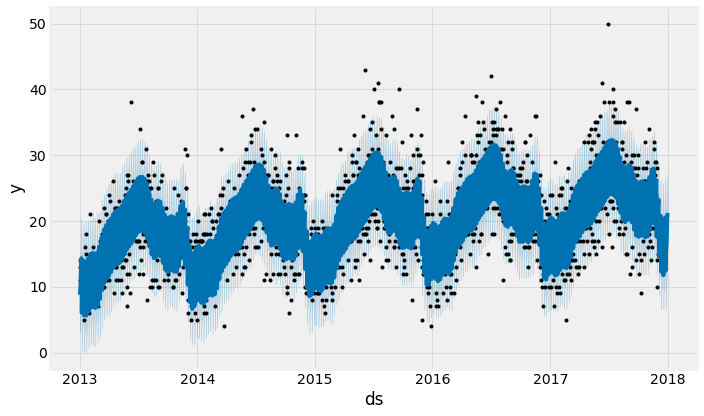

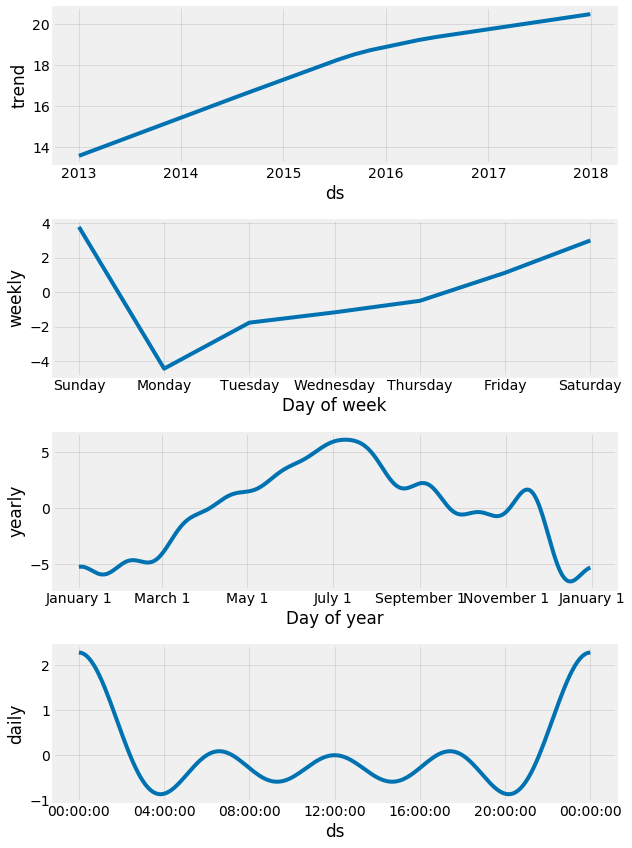

In [26]:
m.plot(forecast)
m.plot_components(forecast)

Based on Prophet's decomposition of seasonality, the forecast shows that sales of item 1 at store 1 peak weekly on Saturday and Sunday, and yearly in July and in November. This suggests that annual events and holidays in July and November could be taken into consideration when making predictions for this sales data. Assuming that the sales data is for stores based in the US, Independence Day, the play offs, the Super Bowl, and Thanksgiving should be added as holidays to improve the forecast.

In [27]:
# Make the holiday data frame
fourth = pd.DataFrame({
    'holiday' : 'Independence Day',
    'ds' : pd.to_datetime(['2013-07-04','2014-07-04','2015-07-04','2016-07-04','2017-07-04']),
    'lower_window': 0,
    'upper_window': 1
})
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3
})

holidays = pd.concat((fourth, playoffs, superbowls))

In [28]:
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(prophet_train[['ds','y']])

In [29]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
1823,2017-12-29
1824,2017-12-30
1825,2017-12-31


In [30]:
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Independence Day,Independence Day_lower,Independence Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,playoff,playoff_lower,playoff_upper,superbowl,superbowl_lower,superbowl_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2017-12-29,20.497666,12.793310,24.250829,20.497062,20.498303,0.0,0.0,0.0,-1.976720,-1.976720,-1.976720,2.288546,2.288546,2.288546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.115890,1.115890,1.115890,-5.381157,-5.381157,-5.381157,0.0,0.0,0.0,18.520946
1824,2017-12-30,20.499708,14.823029,26.362263,20.499012,20.500402,0.0,0.0,0.0,-0.020200,-0.020200,-0.020200,2.288546,2.288546,2.288546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.997026,2.997026,2.997026,-5.305773,-5.305773,-5.305773,0.0,0.0,0.0,20.479508
1825,2017-12-31,20.501750,15.429519,27.246744,20.501003,20.502529,0.0,0.0,0.0,0.828976,0.828976,0.828976,2.288546,2.288546,2.288546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.787648,3.787648,3.787648,-5.247219,-5.247219,-5.247219,0.0,0.0,0.0,21.330726


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

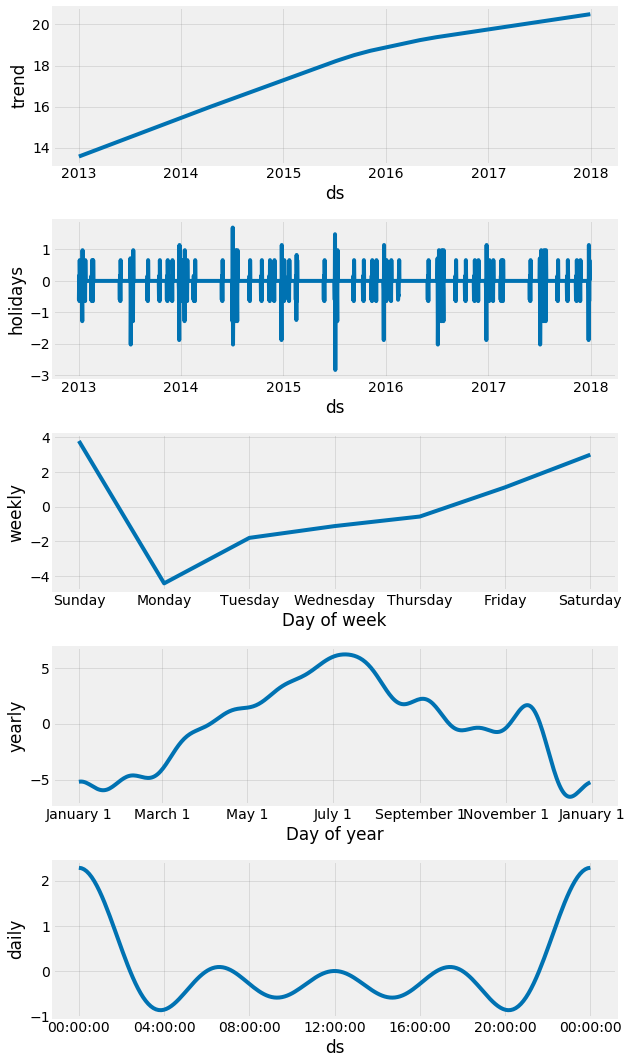

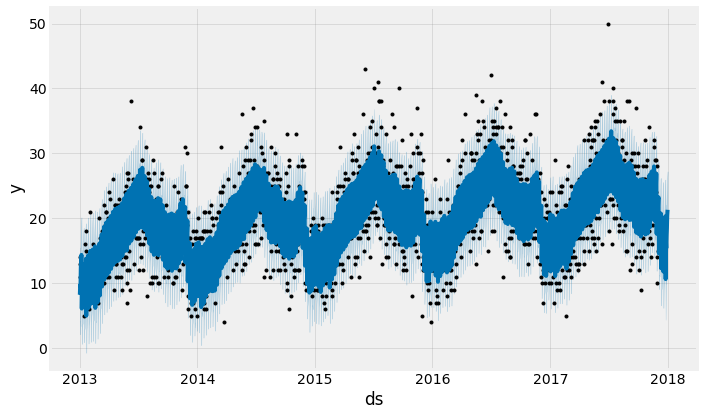

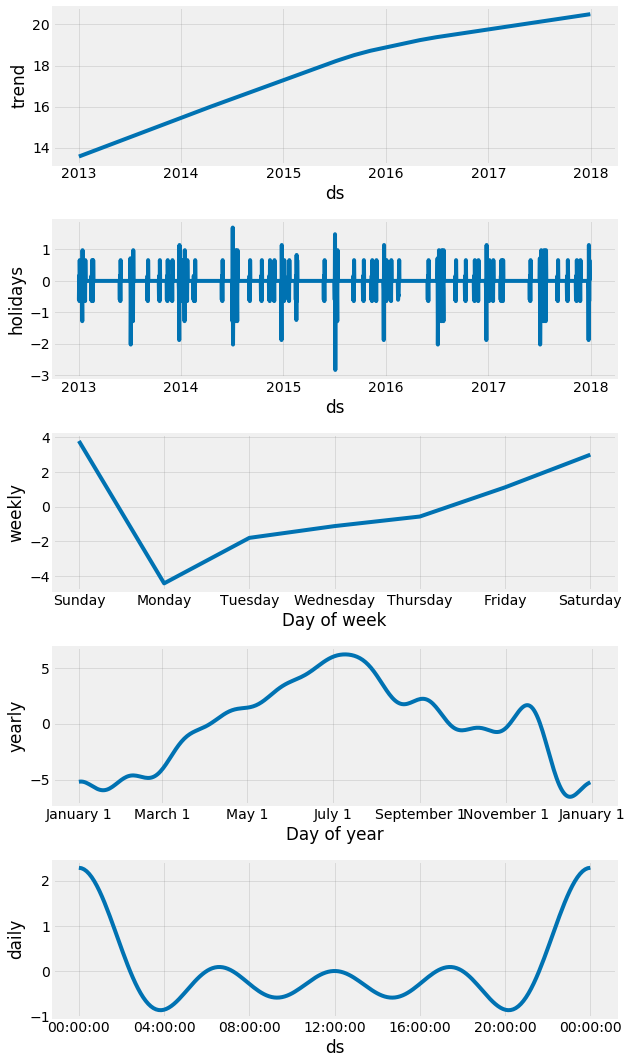

In [31]:
m_holi.plot(forecast_holi)
m_holi.plot_components(forecast_holi)

## Forecast Evaluation

The forecast dataframe contains everything needed for evaluation except the historical data required for comparison.

In [32]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [33]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [34]:
cmp_df = make_comparison_dataframe(prophet_df, forecast)
cmp_df_holi = make_comparison_dataframe(prophet_df, forecast_holi)

We are also going to define a helper function that we will use to gauge the quality of our forecasting with MAPE and MAE error measures:

In [35]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [36]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print('Non Holiday', err_name, err_value)

Non Holiday MAPE 27.49667012665557
Non Holiday MAE 3.5474778019043165


In [37]:
for err_name, err_value in calculate_forecast_errors(cmp_df_holi, prediction_size).items():
    print('Including Holiday', err_name, err_value)

Including Holiday MAPE 27.64935663329023
Including Holiday MAE 3.5466413004468964


As a result, the relative error of our forecast (MAPE) is about 27.5%, and on average our model is wrong by 3.54 predicts (MAE).

In [39]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="aqua"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='sales'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'Sales on Store $1$ for Item $1$')


In [40]:
show_forecast(cmp_df_holi, prediction_size, 100, 'Sales on Store $1$ for Item $1$ Holidays Version')

In [6]:
# Read test set into dataframe
test_data_path = os.path.join(PROJ_ROOT, "data", "raw", "test.csv")

test = pd.read_csv(test_data_path, parse_dates=["date"])
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
id       45000 non-null int64
date     45000 non-null datetime64[ns]
store    45000 non-null int64
item     45000 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB
